# Analysis

In [84]:
import pandas as pd
import plotnine as pn

In [85]:
# Load data

params = [
    0, 1, 2, 4, 8, 16, # nosofsky
    # 0.1, 0.2, 0.5, 0.6, 0.75, 1, 2, 3, 5, 1000 # exp
]

# Learned
# dynamic = "reinforcement_learning"
dynamic = "replicator_dynamic"

# num_trials = 10
num_trials = 100

# similarity = "nosofsky"
similarity = "nosofsky_normed"
# similarity = "exp"
# similarity = "exp_normed"

distortion = "squared_dist"
# distortion = "abs_dist"

out = "multirun"
# out = "outputs"

# trajectory = True
trajectory = False


#############################################################################
# Below three saved in outputs, not multirun

# Pareto frontier
curve_fn = f"/Users/nathanielimel/lps/projects/rdsg/outputs/states=10/signals=10/distortion={distortion}/curve_points.csv"

# Counterpart points
counterpart_fn = f"/Users/nathanielimel/lps/projects/rdsg/outputs/states=10/signals=10/distortion={distortion}/counterpart_points.csv"

# Explored hypothetical systems
sampled_fn = f"/Users/nathanielimel/lps/projects/rdsg/outputs/states=10/signals=10/distortion={distortion}/sampled_points.csv"

#############################################################################
# Typically saved in multirun
# Simulation points
param_fns = {
    f"{float(param)}":f"/Users/nathanielimel/lps/projects/rdsg/{out}/states=10/signals=10/distortion={distortion}/similarity={similarity}/dynamics={dynamic}/num_trials={num_trials}/sim_param={param}/simulation_points.csv"
    for param in params
}

variant_fns = {key: val.replace("simulation_points", "variants_points") for key, val in param_fns.items()}

if trajectory:
    param_fns = {key: val.replace("simulation_points", "mean_points") for key, val in param_fns.items()}



In [86]:
# load dataframes
curve_data = pd.read_csv(curve_fn)
counterpart_data = pd.read_csv(counterpart_fn)
sampled_data = pd.read_csv(sampled_fn)

simulation_dataframes = {
    k: pd.read_csv(param_fns[k]) for k in param_fns
}

variant_dataframes = {
    k: pd.read_csv(variant_fns[k]) for k in variant_fns
}

In [87]:
param_names = {"exp": "beta", "nosofsky": "alpha"}
for name in param_names:
    if name in similarity:
        param_name = param_names[name]

# combine simulation dataframes
for key in simulation_dataframes:
    df = simulation_dataframes[key]
    df[param_name] = key # use string for category

sim_data = pd.concat(simulation_dataframes.values())
sim_data

,rate,distortion,alpha
0,3.121928e+00,3.600000,0.0
1,2.721928e+00,2.900000,0.0
2,2.646439e+00,7.799986,0.0
3,3.121928e+00,0.900000,0.0
4,3.121928e+00,1.600000,0.0
...,...,...,...
95,5.980023e-07,14.499976,16.0
96,1.882065e-03,14.477780,16.0
97,6.362426e-07,28.499971,16.0
98,4.791585e-05,20.498384,16.0


In [88]:
# combine variant dataframes
# combine simulation dataframes
for key in variant_dataframes:
    df = variant_dataframes[key]
    df[param_name] = key # use string for category

variant_data = pd.concat(variant_dataframes.values())
variant_data

,rate,distortion,alpha
0,3.027853,18.293286,0.0
1,2.951581,15.919964,0.0
2,2.846439,6.193107,0.0
3,2.951581,13.827393,0.0
4,2.921928,15.134286,0.0
...,...,...,...
995,0.014641,16.268981,16.0
996,0.015419,16.914568,16.0
997,0.012632,16.981007,16.0
998,0.017114,16.989277,16.0


In [89]:
sim_data[param_name] = sim_data[param_name].astype(float)
sim_data[param_name] = sim_data[param_name].astype(str)
counterpart_data[param_name] = counterpart_data[param_name].astype(float)
counterpart_data[param_name] = counterpart_data[param_name].astype(str)

sim_data

,rate,distortion,alpha
0,3.121928e+00,3.600000,0.0
1,2.721928e+00,2.900000,0.0
2,2.646439e+00,7.799986,0.0
3,3.121928e+00,0.900000,0.0
4,3.121928e+00,1.600000,0.0
...,...,...,...
95,5.980023e-07,14.499976,16.0
96,1.882065e-03,14.477780,16.0
97,6.362426e-07,28.499971,16.0
98,4.791585e-05,20.498384,16.0


In [90]:
# plot each language, with a unique color for each gamma

# hard to clean this up with pd.Categorical
if param_name == "alpha":
    counterpart_data = counterpart_data.assign(
            alpha=pd.Categorical(
                counterpart_data["alpha"], 
                categories=[g for g in simulation_dataframes.keys()]
            )
        )

    sim_data = sim_data.assign(
            alpha=pd.Categorical(
                sim_data["alpha"], 
                categories=[g for g in simulation_dataframes.keys()]
            )
        )
else:
    counterpart_data = counterpart_data.assign(
            beta=pd.Categorical(
                counterpart_data["beta"], 
                categories=[g for g in simulation_dataframes.keys()]
            )
        )

    sim_data = sim_data.assign(
            beta=pd.Categorical(
                sim_data["beta"], 
                categories=[g for g in simulation_dataframes.keys()]
            )
        )


# Language keys
sim_data["language"] = {"reinforcement_learning": "learned", "replicator_dynamic": "evolved"}[dynamic]
counterpart_data["language"] = "optimal counterpart"
all_data = pd.concat([counterpart_data, sim_data])

sampled_data["language"] = "hypothetical"
variant_data["language"] = "hypothetical"

# Trajectory keys
if trajectory:
    sim_data["time step"] = sim_data["round"]

counterpart_data


,rate,distortion,beta,alpha,language
0,3.321928,0.000000,1000.000000,0.0,optimal counterpart
1,1.862177,0.485048,1.000000,1.0,optimal counterpart
2,0.963131,1.822883,0.250000,2.0,optimal counterpart
3,0.057531,7.616357,0.062500,4.0,optimal counterpart
4,0.001560,8.380513,0.015625,8.0,optimal counterpart
5,0.000248,8.845957,0.003906,16.0,optimal counterpart


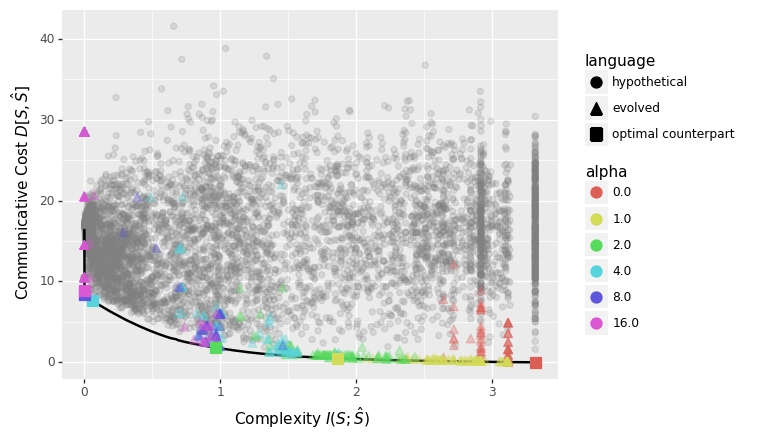

In [91]:
plot = (
    # Set data and the axes
    pn.ggplot(
        data=curve_data, mapping=pn.aes(x="rate", y="distortion")
    )  
    + pn.geom_point(  # sampled langs
        # sampled_data,
        variant_data,
        pn.aes(shape="language"),
        color="gray",
        size=2,
        alpha=0.2,
    )
    + pn.geom_line(size=1) # pareto data                   
    + pn.geom_jitter( # simulation langs
        data=sim_data,
        mapping=pn.aes(
            color=param_name, 
            shape="language",
            ),
        alpha=0.3,
        size=3,
        # height=0.1,
    )
    + pn.geom_point( # theoretical bound langs last
        data=counterpart_data,
        mapping=pn.aes(
            color=param_name,
            shape="language",
            ),
        size=4,
    )    
    + pn.xlab("Complexity $I(S;\hat{S})$")
    + pn.ylab("Communicative Cost $D[S, \hat{S}]$")
)
print(plot)

In [92]:
# # Save plot (will overwrite!)

plot_save_dir = f"/Users/nathanielimel/lps/projects/rdsg/multirun/states=10/signals=10/distortion={distortion}/similarity={similarity}/dynamics={dynamic}/num_trials={num_trials}"
fn = plot_save_dir + f"/multiple_{param_name}.png"
plot.save(filename=fn, width=10, height=10, dpi=300)
print(fn)

/Users/nathanielimel/miniforge3/envs/rdsg/lib/python3.10/site-packages/plotnine/ggplot.py:718: PlotnineWarning: Saving 10 x 10 in image.
/Users/nathanielimel/miniforge3/envs/rdsg/lib/python3.10/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Filename: /Users/nathanielimel/lps/projects/rdsg/multirun/states=10/signals=10/distortion=squared_dist/similarity=nosofsky_normed/dynamics=replicator_dynamic/num_trials=100/multiple_alpha.png


/Users/nathanielimel/lps/projects/rdsg/multirun/states=10/signals=10/distortion=squared_dist/similarity=nosofsky_normed/dynamics=replicator_dynamic/num_trials=100/multiple_alpha.png


## Plot trajectories

In [93]:
# Load data
mean_traj_fns = {
    key: val.replace("simulation_points", "mean_points") for key, val in param_fns.items()
}

mean_traj_dataframes = {
    k: pd.read_csv(mean_traj_fns[k]) for k in mean_traj_fns
}

# combine simulation dataframes
for key in mean_traj_dataframes:
    df = mean_traj_dataframes[key]
    df["alpha"] = key # use string for category

mean_traj_data = pd.concat(mean_traj_dataframes.values())
mean_traj_data = mean_traj_data.dropna() # unnecessary if all files were trajectories
mean_traj_data

,rate,distortion,round,alpha
0,0.007441,16.484485,0,0.0
1,0.063773,15.825094,1,0.0
2,0.600350,12.339445,2,0.0
3,1.760214,7.261424,3,0.0
4,2.518333,4.203935,4,0.0
...,...,...,...,...
195,0.139133,13.659197,195,16.0
196,0.139536,13.653757,196,16.0
197,0.139996,13.646922,197,16.0
198,0.140527,13.638540,198,16.0


In [94]:
# call it alpha
mean_traj_data["perceptual imprecision"] = mean_traj_data["alpha"]

In [95]:
# Plot trajectories, one for each alpha
mean_traj_data = mean_traj_data.assign(
    alpha=pd.Categorical(
        mean_traj_data["alpha"],
        categories=[g for g in simulation_dataframes.keys()]
    )
)

mean_traj_data["language"] = {"reinforcement_learning": "learned", "replicator_dynamic": "evolved"}[dynamic]


In [96]:
# Extract the final rounds

final_round = mean_traj_data["round"].max()
final_round_data = mean_traj_data[mean_traj_data["round"] == final_round]


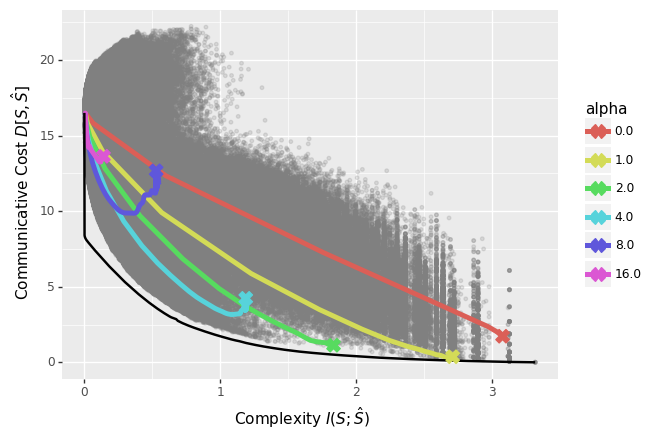

In [97]:
plot = (
    # Set data and the axes
    pn.ggplot(
            data=curve_data, mapping=pn.aes(x="rate", y="distortion")
    )  # pareto data    
    + pn.geom_point(  # sampled langs
        sampled_data,
        # pn.aes(shape="language"),
        color="gray",
        shape="o",
        size=1,
        alpha=0.2,
    )
    + pn.geom_line(  # simulation langs
        data=mean_traj_data,
        mapping=pn.aes(color="alpha"),
        # shape="o",
        alpha=1.0,
        size=2,
    )
    + pn.geom_line(size=1) # pareto     
    + pn.geom_point(  # final langs
        data=final_round_data,
        mapping=pn.aes(color="alpha"),
        shape="X",
        alpha=1.0,
        size=5,
    )
    + pn.xlab("Complexity $I(S;\hat{S})$")
    + pn.ylab("Communicative Cost $D[S, \hat{S}]$")
)
print(plot)

In [98]:
# Save plot (will overwrite!)

plot_save_dir = f"/Users/nathanielimel/lps/projects/rdsg/multirun/states=10/signals=10/distortion={distortion}/similarity={similarity}/dynamics={dynamic}/num_trials={num_trials}"
fn = plot_save_dir + "/alpha_trajectories.png"
plot.save(filename=fn, width=10, height=10, dpi=300)

/Users/nathanielimel/miniforge3/envs/rdsg/lib/python3.10/site-packages/plotnine/ggplot.py:718: PlotnineWarning: Saving 10 x 10 in image.
/Users/nathanielimel/miniforge3/envs/rdsg/lib/python3.10/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Filename: /Users/nathanielimel/lps/projects/rdsg/multirun/states=10/signals=10/distortion=squared_dist/similarity=nosofsky_normed/dynamics=replicator_dynamic/num_trials=100/alpha_trajectories.png


# Perform statistical analyses

### Measure optimality

In [99]:
# N.B.: The reason we need to copypaste this function is because it is sometimes more convenient to measure optimality all at once here, instead of running python script in a hydra sweep (if I forgot to)
import numpy as np
from scipy.spatial.distance import cdist

def measure_optimality(data: pd.DataFrame, curve_data: pd.DataFrame) -> np.ndarray:
    """Compute the min distance to any point on the frontier, for every point. Requires `data` to contain more than one row."""
    # get curve points as list of pairs
    pareto_points = np.array(list(curve_data[["rate", "distortion"]].itertuples(index=False, name=None)))
    points = np.array(list(data[["rate", "distortion"]].itertuples(index=False, name=None)))
    # N.B.: do not interpolate, so you don't measure high-dist random langs as more optimal than they are!

    # Measure closeness of each language to any frontier point
    distances = cdist(points, pareto_points)
    min_distances = np.min(distances, axis=1)

    # max complexity will be achieved by B-A    
    max_complexity = pareto_points[:, 0].max()
    # points may have higher cost than pareto max cost    
    max_cost = max(points[:,1].max(), pareto_points[:,].max())
    # max possible distance is sqrt( max_rate^2 + (max_distortion)^2 )
    max_distance = np.sqrt(max_cost**2 + max_complexity**2)

    # just use the max found distance? 
    # max_distance = np.max(min_distances)
    # min_distances /= max_distance

    optimalities = 1 - min_distances
    return optimalities
    
    # return min_distances

In [ ]:
sim_data["deviation from optimality"] = measure_optimality(sim_data, curve_data)
variant_data["deviation from optimality"] = measure_optimality(variant_data, curve_data)
sampled_data["deviation from optimality"] = measure_optimality(sampled_data, curve_data)


In [ ]:
display(sim_data.mean())
display(variant_data.mean())


/var/folders/3z/q1pyp9n929z2nh_1_69s7y_40000gn/T/ipykernel_40562/1926105380.py:1: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.


rate                         1.587179
distortion                   5.804255
deviation from optimality    1.510969
dtype: float64

/var/folders/3z/q1pyp9n929z2nh_1_69s7y_40000gn/T/ipykernel_40562/1926105380.py:2: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.


rate                          1.259369
distortion                   15.356418
deviation from optimality     2.497987
dtype: float64

In [101]:
sim_data.min()

/var/folders/3z/q1pyp9n929z2nh_1_69s7y_40000gn/T/ipykernel_40562/1256757192.py:1: FutureWarning: The default value of numeric_only in DataFrame.min is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.


rate                             0.0
distortion                       0.0
language                     evolved
deviation from optimality        0.0
dtype: object

### Show optimality in violin plots
*N.B.: need to change python interpreter to 'seaborn'!*

In [ ]:
# N.B.: good violin plots requires seaborn 0.12.2, which is incompatible with plotnine
import seaborn as sns
import matplotlib.pyplot as plt
plt.ion()
sns.set_theme()

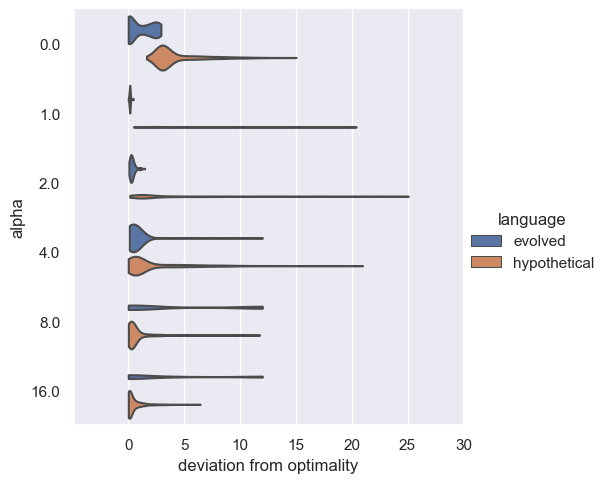

In [104]:

data = pd.concat([sim_data, variant_data])

violin = sns.catplot(
    data=data, y="alpha", x="deviation from optimality", hue="language", kind="violin", inner=None, split=False, cut=0,
)

violin.set(xlim=(-4.9, 30))

# sns.catplot(
#     data=tips, x="day", y="total_bill", hue="sex",
#     kind="violin", inner="stick", split=True, palette="pastel",
# )

plt.show()

/Users/nathanielimel/miniforge3/envs/rdsg/lib/python3.10/site-packages/seaborn/distributions.py:1185: UserWarning: No contour levels were found within the data range.


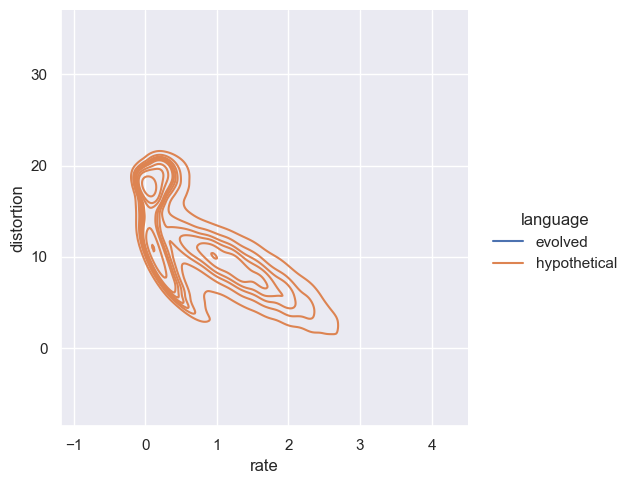

In [ ]:
# what does sampled_data look like?

data = pd.concat([sim_data, sampled_data])

sns.displot(data=data, x="rate", y="distortion", hue="language", kind="kde")

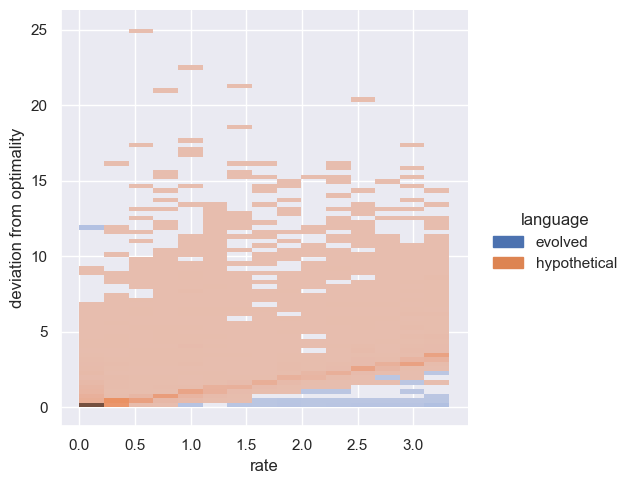

In [ ]:
# what does hypothetical look like?
data = pd.concat([sim_data, variant_data])

sns.displot(data=data, x="rate", y="deviation from optimality", hue="language",)

<Figure size 640x480 with 0 Axes>

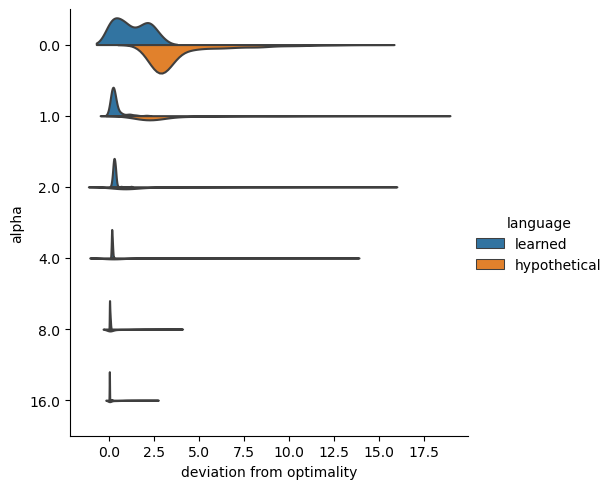

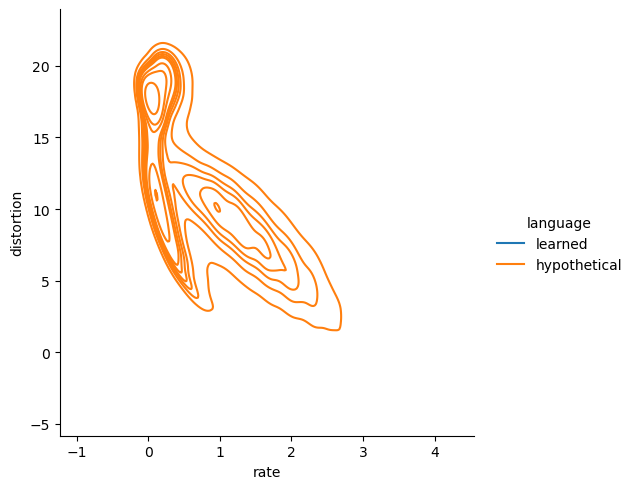